# Phase 5: Advanced Analytics

This notebook implements advanced analytics including clustering, forecasting, and causal inference.

## Objectives
1. Customer and product segmentation using clustering
2. Time series forecasting of reviews and ratings
3. Causal inference analysis
4. Advanced pattern discovery
5. Predictive analytics beyond sentiment


## 1. Setup and Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed" / "fused"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
MODELS_DIR = PROJECT_ROOT / "models"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")


Project root: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights


## 2. Load Data


In [3]:
import pyarrow.parquet as pq
import gc

fused_file = PROCESSED_DIR / "books_books_fused.parquet"

if fused_file.exists():
    parquet_file = pq.ParquetFile(fused_file)
    num_rows = parquet_file.metadata.num_rows
    num_row_groups = parquet_file.num_row_groups
    
    SAMPLE_SIZE = 200_000
    
    if num_rows > SAMPLE_SIZE:
        max_row_groups_to_try = min(30, num_row_groups)
        rng = np.random.RandomState(42)
        row_groups_to_try = sorted(rng.choice(num_row_groups, 
                                              size=max_row_groups_to_try, 
                                              replace=False))
        
        batches = []
        
        for rg_idx in row_groups_to_try:
            try:
                batch = parquet_file.read_row_groups([rg_idx]).to_pandas()
                
                for col in batch.columns:
                    if batch[col].dtype == 'object':
                        sample_vals = batch[col].dropna().head(5)
                        if len(sample_vals) > 0 and any(isinstance(val, dict) for val in sample_vals):
                            batch[col] = batch[col].astype(str)
                
                batches.append(batch)
                
                total_rows = sum(len(b) for b in batches)
                if total_rows >= SAMPLE_SIZE * 1.5:
                    break
            except Exception:
                continue
        
        if batches:
            df_temp = pd.concat(batches, ignore_index=True)
            
            if len(df_temp) > SAMPLE_SIZE:
                df = df_temp.sample(n=SAMPLE_SIZE, random_state=42)
            else:
                df = df_temp.copy()
            
            del batches, df_temp
            gc.collect()
        else:
            raise ValueError("Could not read any data from parquet file")
    else:
        df = pd.read_parquet(fused_file)
    
    if 'helpfulness_ratio' in df.columns:
        df['helpfulness_ratio'] = pd.to_numeric(df['helpfulness_ratio'], errors='coerce')
    
    if 'review_datetime' in df.columns:
        df['review_datetime'] = pd.to_datetime(df['review_datetime'], errors='coerce')
    
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['review_datetime'].min()} to {df['review_datetime'].max()}")
else:
    raise FileNotFoundError(f"File not found: {fused_file}")


Dataset shape: (200000, 50)
Date range: 1997-08-11 00:00:00+00:00 to 2018-05-01 00:00:00+00:00


## 3. Customer Segmentation (Clustering)


In [4]:
customer_features = df.groupby('reviewerID').agg({
    'overall': ['mean', 'count', 'std'],
    'helpfulness_ratio': 'mean',
    'review_length_words': 'mean',
    'is_verified': 'sum'
}).reset_index()

customer_features.columns = ['reviewerID', 'avg_rating', 'num_reviews', 'rating_std', 
                            'avg_helpfulness', 'avg_review_length', 'verified_count']
customer_features = customer_features.fillna(0)

scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features[['avg_rating', 'num_reviews', 
                                                                    'rating_std', 'avg_helpfulness',
                                                                    'avg_review_length', 'verified_count']])

print(f"Customer features shape: {customer_features.shape}")
print(f"Features: {customer_features.columns.tolist()}")


Customer features shape: (154086, 7)
Features: ['reviewerID', 'avg_rating', 'num_reviews', 'rating_std', 'avg_helpfulness', 'avg_review_length', 'verified_count']


### 3.1 Determine Optimal Number of Clusters


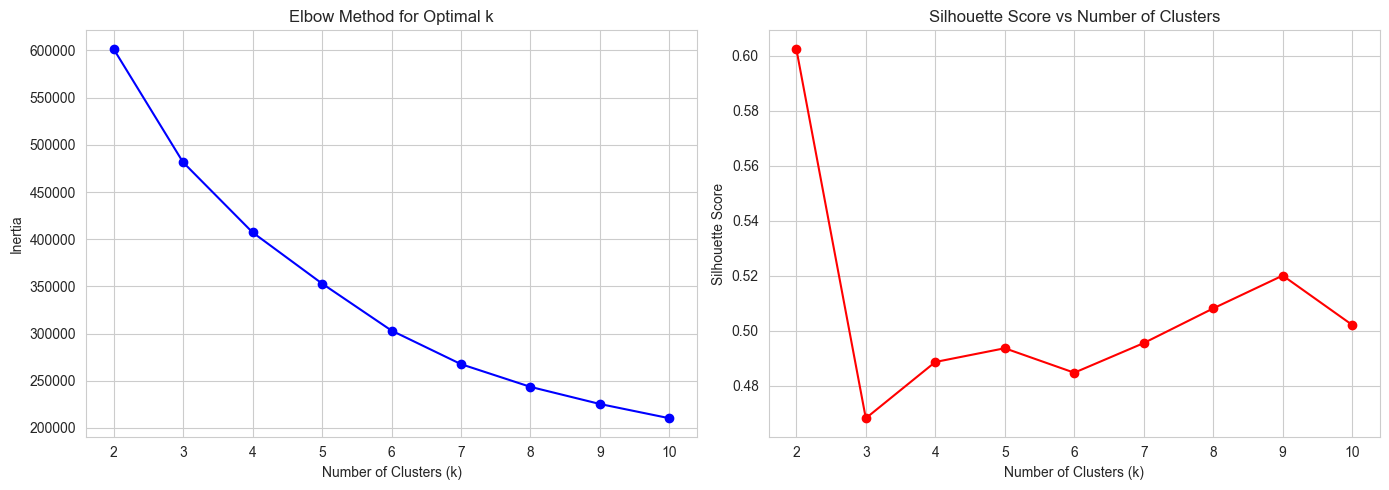

Optimal number of clusters: 2 (Silhouette score: 0.6024)


In [7]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_features_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_features_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'customer_clustering_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k} (Silhouette score: {max(silhouette_scores):.4f})")


### 3.2 Apply K-Means Clustering


Customer Cluster Summary:
         Avg Rating  Avg Num Reviews  Rating Std  Avg Helpfulness  \
cluster                                                             
0             3.882            3.461       1.041              0.0   
1             4.326            1.094       0.004              0.0   

         Avg Review Length  Avg Verified   Count  
cluster                                           
0                  194.787         1.448   13269  
1                   75.693         0.787  140817  


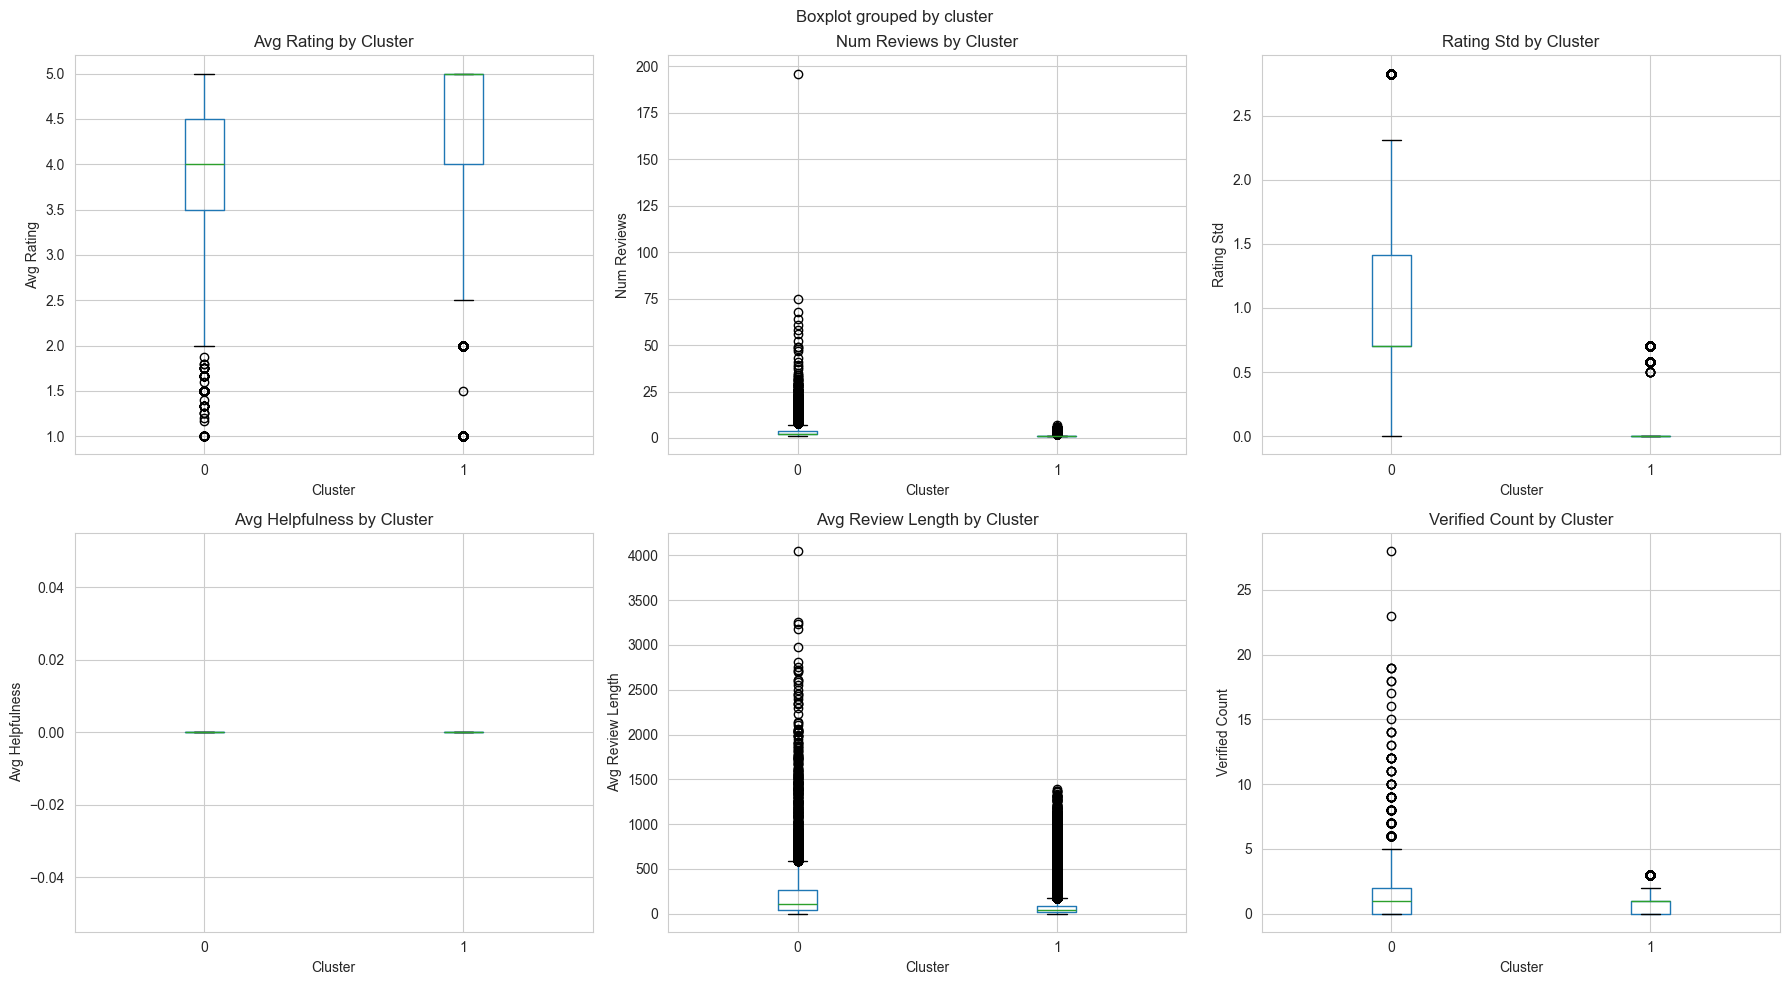

In [8]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['cluster'] = kmeans.fit_predict(customer_features_scaled)

cluster_summary = customer_features.groupby('cluster').agg({
    'avg_rating': 'mean',
    'num_reviews': 'mean',
    'rating_std': 'mean',
    'avg_helpfulness': 'mean',
    'avg_review_length': 'mean',
    'verified_count': 'mean',
    'reviewerID': 'count'
}).round(3)

cluster_summary.columns = ['Avg Rating', 'Avg Num Reviews', 'Rating Std', 
                          'Avg Helpfulness', 'Avg Review Length', 'Avg Verified', 'Count']
print("Customer Cluster Summary:")
print(cluster_summary)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

features_to_plot = ['avg_rating', 'num_reviews', 'rating_std', 
                    'avg_helpfulness', 'avg_review_length', 'verified_count']
feature_names = ['Avg Rating', 'Num Reviews', 'Rating Std', 
                'Avg Helpfulness', 'Avg Review Length', 'Verified Count']

for idx, (feat, name) in enumerate(zip(features_to_plot, feature_names)):
    customer_features.boxplot(column=feat, by='cluster', ax=axes[idx])
    axes[idx].set_title(f'{name} by Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(name)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'customer_clusters_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Product Segmentation


In [9]:
product_features = df.groupby('asin').agg({
    'overall': ['mean', 'count', 'std'],
    'helpfulness_ratio': 'mean',
    'review_length_words': 'mean',
    'is_verified': 'sum'
}).reset_index()

product_features.columns = ['asin', 'avg_rating', 'num_reviews', 'rating_std',
                           'avg_helpfulness', 'avg_review_length', 'verified_count']
product_features = product_features.fillna(0)
product_features = product_features[product_features['num_reviews'] >= 5]

scaler_product = StandardScaler()
product_features_scaled = scaler_product.fit_transform(
    product_features[['avg_rating', 'num_reviews', 'rating_std', 
                     'avg_helpfulness', 'avg_review_length', 'verified_count']]
)

print(f"Product features shape: {product_features.shape}")
print(f"Products with at least 5 reviews: {len(product_features)}")


Product features shape: (3438, 7)
Products with at least 5 reviews: 3438


In [10]:
silhouette_scores_product = []
k_range_product = range(2, 8)

for k in k_range_product:
    kmeans_product = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_product.fit_predict(product_features_scaled)
    silhouette_scores_product.append(silhouette_score(product_features_scaled, labels))

optimal_k_product = k_range_product[np.argmax(silhouette_scores_product)]
print(f"Optimal number of product clusters: {optimal_k_product}")

kmeans_product = KMeans(n_clusters=optimal_k_product, random_state=42, n_init=10)
product_features['cluster'] = kmeans_product.fit_predict(product_features_scaled)

product_cluster_summary = product_features.groupby('cluster').agg({
    'avg_rating': 'mean',
    'num_reviews': 'mean',
    'rating_std': 'mean',
    'avg_helpfulness': 'mean',
    'avg_review_length': 'mean',
    'verified_count': 'mean',
    'asin': 'count'
}).round(3)

product_cluster_summary.columns = ['Avg Rating', 'Avg Num Reviews', 'Rating Std',
                                   'Avg Helpfulness', 'Avg Review Length', 'Avg Verified', 'Count']
print("\nProduct Cluster Summary:")
print(product_cluster_summary)


Optimal number of product clusters: 4

Product Cluster Summary:
         Avg Rating  Avg Num Reviews  Rating Std  Avg Helpfulness  \
cluster                                                             
0             3.834           36.230       1.214              0.0   
1             4.562           51.096       0.706              0.0   
2             3.839         7610.000       1.260              0.0   
3             4.375         1421.630       0.972              0.0   

         Avg Review Length  Avg Verified  Count  
cluster                                          
0                  188.359        18.041   1593  
1                  118.385        35.778   1817  
2                   63.294      6022.000      1  
3                   73.978      1063.259     27  


## 5. Time Series Forecasting


In [11]:
df['review_date'] = pd.to_datetime(df['review_datetime'], errors='coerce')
df = df.dropna(subset=['review_date'])

daily_stats = df.groupby(df['review_date'].dt.date).agg({
    'overall': ['mean', 'count'],
    'reviewerID': 'nunique',
    'asin': 'nunique'
}).reset_index()

daily_stats.columns = ['date', 'avg_rating', 'num_reviews', 'unique_reviewers', 'unique_products']
daily_stats['date'] = pd.to_datetime(daily_stats['date'])
daily_stats = daily_stats.sort_values('date')
daily_stats = daily_stats.set_index('date')

print(f"Time series range: {daily_stats.index.min()} to {daily_stats.index.max()}")
print(f"Total days: {len(daily_stats)}")
print(f"\nDaily statistics sample:")
print(daily_stats.head(10))


Time series range: 1997-08-11 00:00:00 to 2018-05-01 00:00:00
Total days: 6782

Daily statistics sample:
            avg_rating  num_reviews  unique_reviewers  unique_products
date                                                                  
1997-08-11         5.0            1                 1                1
1997-08-15         5.0            1                 1                1
1997-08-18         5.0            1                 1                1
1997-08-22         5.0            1                 1                1
1997-08-27         5.0            1                 1                1
1997-09-20         5.0            1                 1                1
1997-09-22         3.0            1                 1                1
1997-09-26         4.0            1                 1                1
1997-10-04         4.0            1                 1                1
1997-10-11         3.0            1                 1                1


### 5.1 Time Series Decomposition


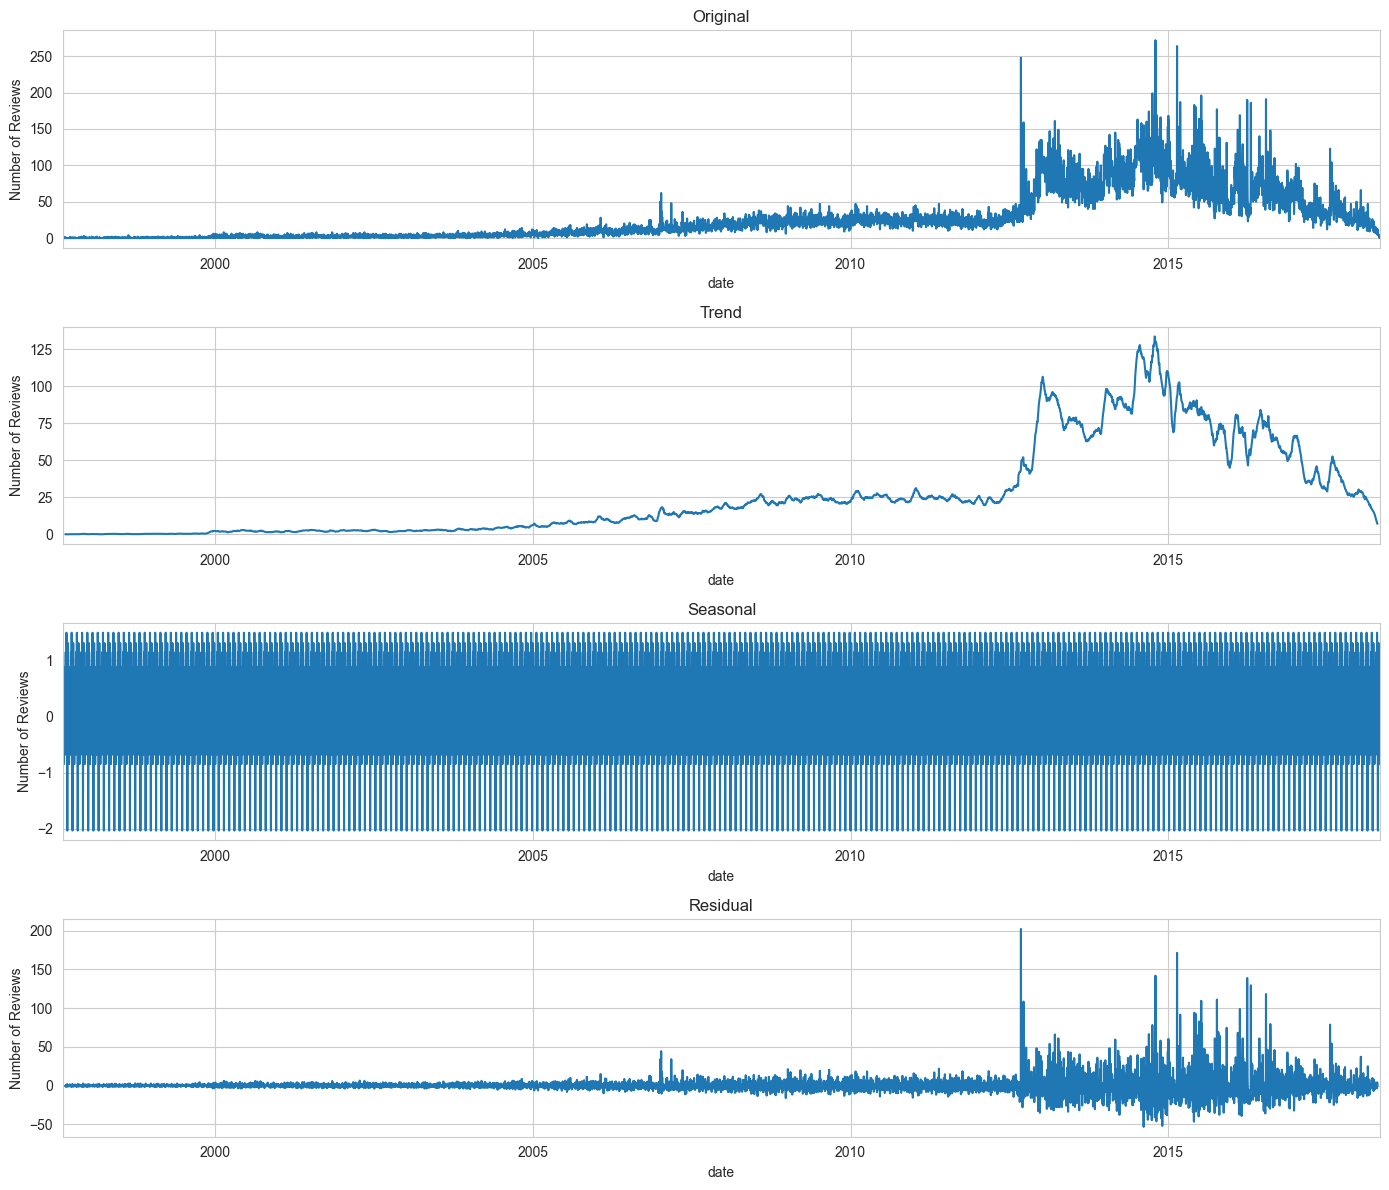

ADF Statistic: -2.1541
p-value: 0.2233
Critical Values: {'1%': np.float64(-3.4312184984100775), '5%': np.float64(-2.86192381078607), '10%': np.float64(-2.5669742980539185)}
Series is non-stationary


In [12]:
ts_reviews = daily_stats['num_reviews'].resample('D').sum()
ts_reviews = ts_reviews.ffill().fillna(0)

if len(ts_reviews) > 30:
    decomposition = seasonal_decompose(ts_reviews, model='additive', period=30)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    
    for ax in axes:
        ax.set_ylabel('Number of Reviews')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'time_series_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    result = adfuller(ts_reviews.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is non-stationary")


### 5.2 ARIMA Forecasting


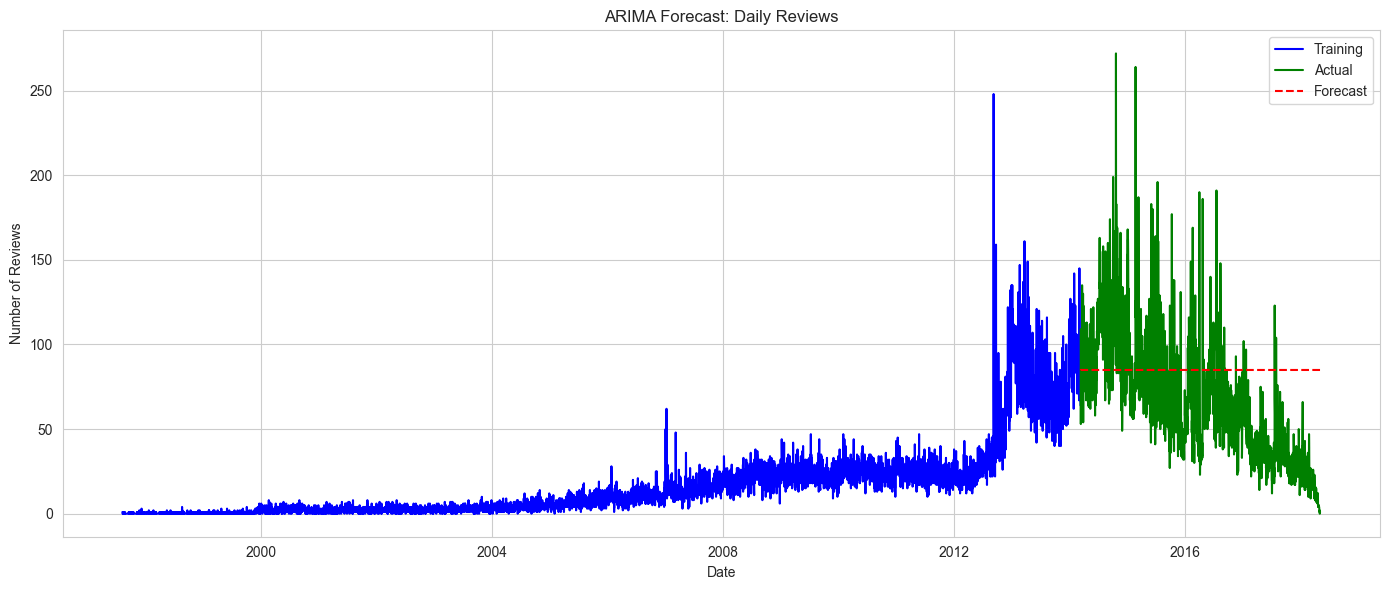

MAE: 33.52
RMSE: 40.26


In [13]:
train_size = int(len(ts_reviews) * 0.8)
train = ts_reviews[:train_size]
test = ts_reviews[train_size:]

try:
    model = ARIMA(train, order=(1, 1, 1))
    fitted_model = model.fit()
    
    forecast = fitted_model.forecast(steps=len(test))
    forecast_index = test.index
    
    plt.figure(figsize=(14, 6))
    plt.plot(train.index, train.values, label='Training', color='blue')
    plt.plot(test.index, test.values, label='Actual', color='green')
    plt.plot(forecast_index, forecast, label='Forecast', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.title('ARIMA Forecast: Daily Reviews')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'arima_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    mae = np.mean(np.abs(forecast - test.values))
    rmse = np.sqrt(np.mean((forecast - test.values)**2))
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
except Exception as e:
    print(f"ARIMA modeling failed: {e}")


## 6. Causal Inference Analysis


Correlation Matrix:
                     overall  helpfulness_ratio  is_verified  \
overall                  NaN                NaN          NaN   
helpfulness_ratio        NaN                NaN          NaN   
is_verified              NaN                NaN          NaN   
review_length_words      NaN                NaN          NaN   
review_length_chars      NaN                NaN          NaN   

                     review_length_words  review_length_chars  
overall                              NaN                  NaN  
helpfulness_ratio                    NaN                  NaN  
is_verified                          NaN                  NaN  
review_length_words                  NaN                  NaN  
review_length_chars                  NaN                  NaN  


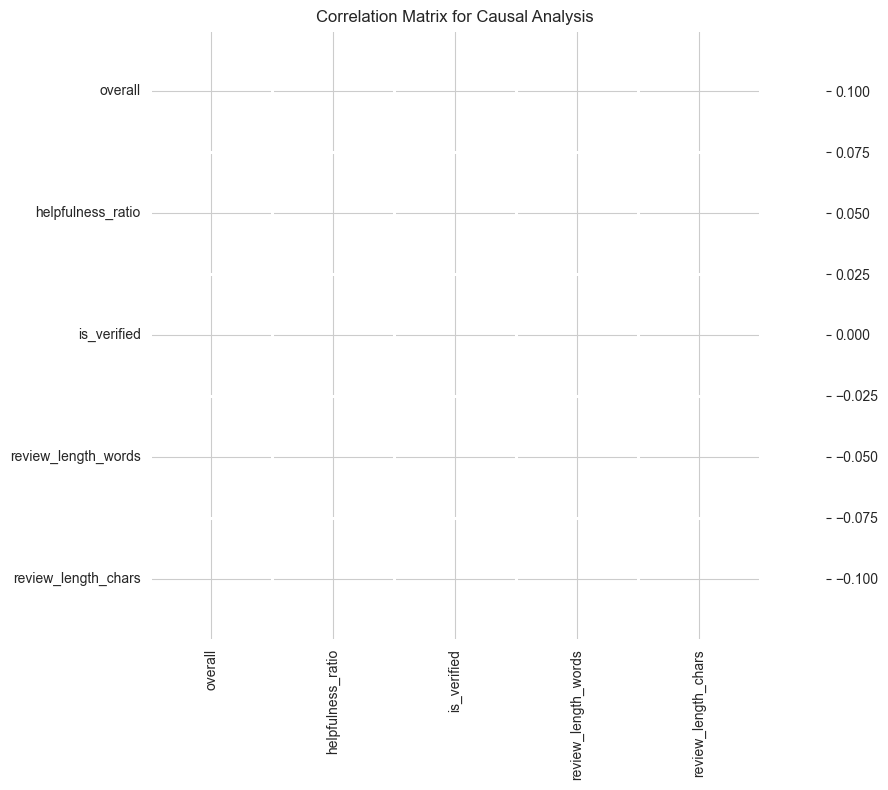

In [14]:
causal_df = df[['overall', 'helpfulness_ratio', 'is_verified', 
                'review_length_words', 'review_length_chars']].dropna()

correlations = causal_df.corr()
print("Correlation Matrix:")
print(correlations)

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix for Causal Analysis')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'causal_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


### 6.1 Impact of Verified Purchase on Rating


Verified purchases - Mean rating: 4.407, Count: 130028
Non-verified purchases - Mean rating: 4.016, Count: 69972

T-test results:
T-statistic: 78.1408
P-value: 0.0000
Significant difference between verified and non-verified ratings


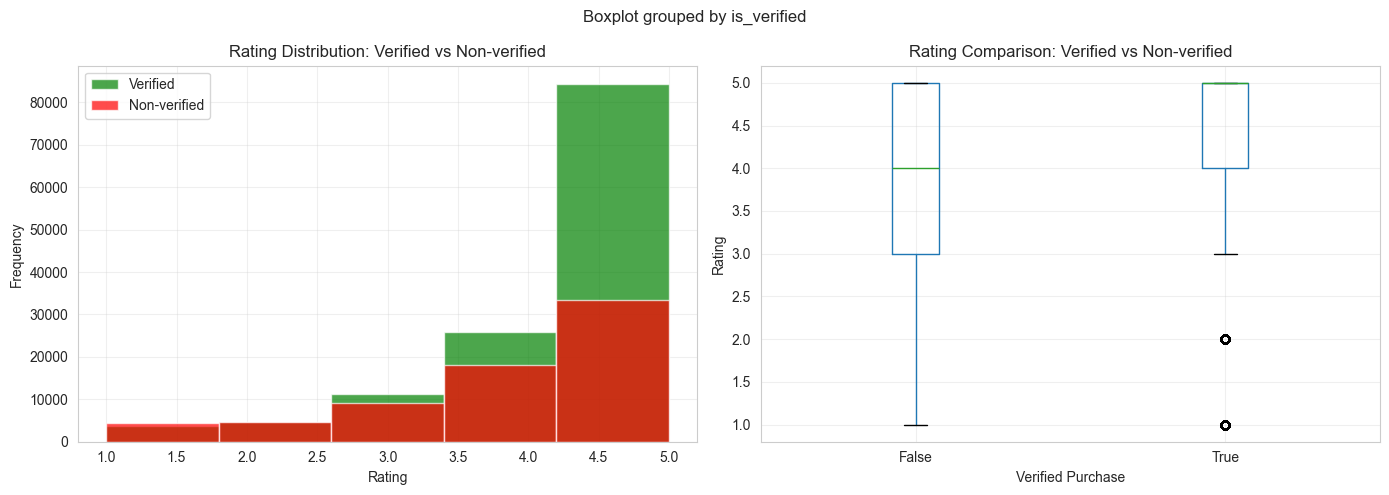

In [15]:
verified_ratings = df[df['is_verified'] == 1]['overall']
non_verified_ratings = df[df['is_verified'] == 0]['overall']

t_stat, p_value = stats.ttest_ind(verified_ratings, non_verified_ratings)

print(f"Verified purchases - Mean rating: {verified_ratings.mean():.3f}, Count: {len(verified_ratings)}")
print(f"Non-verified purchases - Mean rating: {non_verified_ratings.mean():.3f}, Count: {len(non_verified_ratings)}")
print(f"\nT-test results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant difference between verified and non-verified ratings")
else:
    print("No significant difference")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(verified_ratings, bins=5, alpha=0.7, label='Verified', color='green')
axes[0].hist(non_verified_ratings, bins=5, alpha=0.7, label='Non-verified', color='red')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Rating Distribution: Verified vs Non-verified')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

df.boxplot(column='overall', by='is_verified', ax=axes[1])
axes[1].set_xlabel('Verified Purchase')
axes[1].set_ylabel('Rating')
axes[1].set_title('Rating Comparison: Verified vs Non-verified')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'verified_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Summary and Results


In [19]:
print("=" * 80)
print("PHASE 5: ADVANCED ANALYTICS - SUMMARY")
print("=" * 80)

print(f"\n1. Customer Segmentation:")
print(f"   - Optimal clusters: {optimal_k}")
print(f"   - Total customers analyzed: {len(customer_features)}")
print(f"   - Cluster distribution:")
for cluster in sorted(customer_features['cluster'].unique()):
    count = len(customer_features[customer_features['cluster'] == cluster])
    print(f"     Cluster {cluster}: {count} customers")

print(f"\n2. Product Segmentation:")
print(f"   - Optimal clusters: {optimal_k_product}")
print(f"   - Products analyzed: {len(product_features)}")

print(f"\n3. Time Series Analysis:")
print(f"   - Time period: {daily_stats.index.min()} to {daily_stats.index.max()}")
print(f"   - Total days: {len(daily_stats)}")

print(f"\n4. Causal Inference:")
print(f"   - Verified vs Non-verified impact: {'Significant' if p_value < 0.05 else 'Not significant'}")
print("\n" + "=" * 80)
print("All visualizations saved to:", FIGURES_DIR)
print("=" * 80)


PHASE 5: ADVANCED ANALYTICS - SUMMARY

1. Customer Segmentation:
   - Optimal clusters: 2
   - Total customers analyzed: 154086
   - Cluster distribution:
     Cluster 0: 13269 customers
     Cluster 1: 140817 customers

2. Product Segmentation:
   - Optimal clusters: 4
   - Products analyzed: 3438

3. Time Series Analysis:
   - Time period: 1997-08-11 00:00:00 to 2018-05-01 00:00:00
   - Total days: 6782

4. Causal Inference:
   - Verified vs Non-verified impact: Significant

All visualizations saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\reports\figures
